In [1]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5),(0.5))])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
trainset = torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.MNIST(root='./data',train=False,download=True,transform=transform)

cuda:0


In [3]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=False)

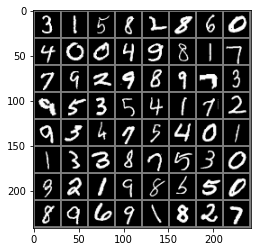

tensor([3, 1, 5, 8, 2, 8, 6, 0, 4, 0, 0, 4, 9, 8, 1, 7, 7, 9, 2, 9, 8, 9, 7, 3,
        9, 5, 3, 5, 4, 1, 7, 2, 9, 3, 6, 7, 5, 4, 0, 1, 1, 3, 3, 8, 7, 5, 3, 0,
        3, 2, 1, 9, 8, 5, 5, 0, 8, 9, 6, 9, 1, 8, 2, 7])


In [39]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)


In [67]:
images.view(64,-1).shape

torch.Size([64, 784])

# 从零开始的神经网络（没有torch.nn）

对于权重，我们在初始化之后设置requires_grad，因为我们不希望该步骤包含在梯度中。 （请注意，PyTorch 中的尾随_表示该操作是原地执行的。）

In [19]:

# xavier 初始化， 1/sqrt(n)
import math
weights = torch.randn(784,10)/math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [5]:
def log_softmax(x):
    return x-x.exp().sum(-1).log().unsqueeze(-1)
def model(xb):
    return log_softmax(xb@weights+bias)

In [71]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
xb = images.view(64,-1)
print(xb.shape,weights.shape)
preds = model(xb)
print(preds[0],preds.shape)

torch.Size([64, 784]) torch.Size([784, 10])
tensor([-3.4079, -2.5385, -2.6084, -1.9595, -2.1396, -4.0570, -1.1501, -3.1212,
        -1.7933, -4.4920], grad_fn=<SelectBackward>) torch.Size([64, 10])


对其进行反向传播,使用负对数可能性作为损失函数

In [10]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()



In [19]:
def accuracy(out, yb):
    preds = torch.argmax(out,dim=1)
    return (preds==yb).float().mean()


定义好各部分函数后，可以开始训练
- 选择一个小批量数据
- 使用模型预测
- 计算损失
- 梯度反向传播
- 更新权重参数


In [20]:
epochs = 2
lr = 0.01
total_loss = 0
for epoch in range(epochs):
    print('==>epoch:',epoch)
    for i,(images,labels) in enumerate(iter(trainloader)):
        if images.shape[0]!=64:
            continue
        pre = model(images.view(64,-1))
        loss = nll(pre, labels)
        total_loss += loss.item()
        loss.backward()
        if i%100 == 99:
            print('loss:',total_loss/100)
            total_loss = 0
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
        

        


==>epoch: 0
loss: 1.396499629020691
loss: 0.7710945135354996
loss: 0.6218611133098603
loss: 0.555510396361351
loss: 0.5235749652981758
loss: 0.4894678857922554
loss: 0.47751743003726005
loss: 0.44590918481349945
loss: 0.43495763957500455
==>epoch: 1
loss: 0.5763407702744007
loss: 0.4104326932132244
loss: 0.38986979573965075
loss: 0.40715831115841866
loss: 0.3864559246599674
loss: 0.38381958201527594
loss: 0.3940538515150547
loss: 0.3705104751884937
loss: 0.36595761626958845


简单看一下预测准确率

In [32]:
testloader = torch.utils.data.DataLoader(testset,batch_size=256,shuffle=False)
dataiter = iter(testloader)
images, labels = dataiter.next()
xb = images.view(256,-1)

preds = model(xb)

print(nll(preds, labels), accuracy(preds, labels))



tensor(0.3023, grad_fn=<NegBackward>) tensor(0.9258)


# 使用torch.nn.functional

In [26]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784,10)
    def forward(self,x):
        x = self.linear(x)
        return x
net = Mnist_Logistic()

In [17]:
loss_func = F.cross_entropy
opt = optim.SGD(net.parameters(), lr=lr)


In [30]:
epochs = 2
lr = 0.01
total_loss = 0
for epoch in range(epochs):
    print('==>epoch:',epoch)
    for i,(images,labels) in enumerate(iter(trainloader)):
        if images.shape[0]!=64:
            continue
        pre = net(images.view(64,-1))
        loss = loss_func(pre, labels)
        total_loss += loss.item()
        loss.backward()
        opt.step()
        opt.zero_grad()
        with torch.no_grad():
            if i%100 == 99:
                print('loss:',total_loss/100)
                total_loss = 0
   


==>epoch: 0
loss: 1.360247254371643
loss: 0.7491458448767662
loss: 0.6104260048270226
loss: 0.5517840164899827
loss: 0.5082033076882362
loss: 0.47187565088272093
loss: 0.4569122210144997
loss: 0.43576705276966093
loss: 0.42878285408020017
==>epoch: 1
loss: 0.5571138669550418
loss: 0.4085775898396969
loss: 0.39701833099126815
loss: 0.39589323595166204
loss: 0.37616617903113364
loss: 0.38766723826527594
loss: 0.38542990282177925
loss: 0.3695705370604992
loss: 0.3725042200088501


In [34]:
testloader = torch.utils.data.DataLoader(testset,batch_size=256,shuffle=False)
dataiter = iter(testloader)
images, labels = dataiter.next()
xb = images.view(256,-1)

preds = net(xb)

print(loss_func(preds, labels), accuracy(preds, labels))



tensor(0.2954, grad_fn=<NllLossBackward>) tensor(0.9336)


重构后可以看到简洁了很多，下面我们使用稍微复杂一点的cnn网络来进行训练

In [53]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,kernel_size=3,padding=1,stride=2)
        self.conv2 = nn.Conv2d(16,64,kernel_size=3,padding=1,stride=2)
        self.conv3 = nn.Conv2d(64,10,kernel_size=3,padding=1,stride=2)
        self.linear = nn.Linear(10*4*4,10)
    def forward(self,x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = x.view(x.shape[0],-1)
        x = self.linear(x)
        return x
net = Mnist_CNN()

opt = optim.SGD(net.parameters(), lr=lr, momentum=0.9)



In [54]:
epochs = 2
lr = 0.01
total_loss = 0
for epoch in range(epochs):
    print('==>epoch:',epoch)
    for i,(images,labels) in enumerate(iter(trainloader)):

        pre = net(images)
        loss = loss_func(pre, labels)
        total_loss += loss.item()
        loss.backward()
        opt.step()
        opt.zero_grad()
        with torch.no_grad():
            if i%100 == 99:
                print('loss:',total_loss/100)
                total_loss = 0
   


==>epoch: 0
loss: 2.141808111667633
loss: 0.6021550539135933
loss: 0.34329138822853567
loss: 0.298346716016531
loss: 0.23863446570932864
loss: 0.19811219334602356
loss: 0.18462276965379715
loss: 0.15867669899016618
loss: 0.15780935157090425
==>epoch: 1
loss: 0.1838945710286498
loss: 0.1354563520476222
loss: 0.1341507482342422
loss: 0.11310762260109186
loss: 0.10466277883388102
loss: 0.10408694420009851
loss: 0.10917020024731755
loss: 0.09052139162085951
loss: 0.09500266593880952


In [56]:
testloader = torch.utils.data.DataLoader(testset,batch_size=256,shuffle=False)
dataiter = iter(testloader)
images, labels = dataiter.next()
xb = images

preds = net(xb)

print(loss_func(preds, labels), accuracy(preds, labels))



tensor(0.0349, grad_fn=<NllLossBackward>) tensor(0.9922)


卷积效果确实好了很多，下面介绍一些方便的模块，对一些简单的网络结构可以使用sequential来创建模型。
对于一些个性化处理可以定义自定义层

In [76]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def preprocess(x):
    return x.view(-1, 1, 28, 28)


net = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
opt = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)#这个每次也需要重新初始化

In [65]:
epochs = 4
lr = 0.01
total_loss = 0
for epoch in range(epochs):
    print('==>epoch:',epoch)
    for i,(images,labels) in enumerate(iter(trainloader)):

        pre = net(images)
        loss = loss_func(pre, labels)
        total_loss += loss.item()
        loss.backward()
        opt.step()
        opt.zero_grad()
        with torch.no_grad():
            if i%100 == 99:
                print('loss:',total_loss/100)
                total_loss = 0
   


==>epoch: 0
loss: 2.279055576324463
loss: 1.5869255900382995
loss: 0.7367198094725609
loss: 0.5142888711392879
loss: 0.45213185250759125
loss: 0.367231956422329
loss: 0.34696184650063516
loss: 0.3106032174825668
loss: 0.3191668452322483
==>epoch: 1
loss: 0.3899407455325127
loss: 0.25693319357931615
loss: 0.23894681110978128
loss: 0.24009726695716382
loss: 0.21921528469771145
loss: 0.20968198830261828
loss: 0.23235028892755508
loss: 0.2167720880359411
loss: 0.20960693869739772
==>epoch: 2
loss: 0.26756823536008595
loss: 0.19338471291586756
loss: 0.19499632619321347
loss: 0.16507892364636065
loss: 0.1833948177471757
loss: 0.1759263669885695
loss: 0.16632117550820114
loss: 0.17932451527565718
loss: 0.16916666898876428
==>epoch: 3
loss: 0.23095717577263714
loss: 0.1637174218520522
loss: 0.1518848273716867
loss: 0.16128576515242457
loss: 0.15556468594819306
loss: 0.14262472219765188
loss: 0.14757041957229375
loss: 0.15266021903604268
loss: 0.15802150761708617


In [67]:
testloader = torch.utils.data.DataLoader(testset,batch_size=256,shuffle=False)
dataiter = iter(testloader)
images, labels = dataiter.next()
xb = images

preds = net(xb)

print(loss_func(preds, labels), accuracy(preds, labels))



tensor(0.1424, grad_fn=<NllLossBackward>) tensor(0.9570)


我们使用GPU来加速训练

In [68]:
print(torch.cuda.is_available())

True


In [4]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def preprocess(x):
    return x.view(-1, 1, 28, 28)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
# 或
net = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

# 或

net.to(dev)
opt = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

In [14]:
epochs = 4
lr = 0.01
total_loss = 0
for epoch in range(epochs):
    print('==>epoch:',epoch)
    for i,(images,labels) in enumerate(iter(trainloader)):

        pre = net(images.to(dev))
        loss = loss_func(pre, labels.to(dev))
        total_loss += loss.item()
        loss.backward()
        opt.step()
        opt.zero_grad()
        with torch.no_grad():
            if i%100 == 99:
                print('loss:',total_loss/100)
                total_loss = 0
   


==>epoch: 0
loss: 2.119110622406006
loss: 1.0884726524353028
loss: 0.5911283293366432
loss: 0.49494563430547717
loss: 0.39078830167651174
loss: 0.3825821404159069
loss: 0.31927334792912004
loss: 0.2894810173660517
loss: 0.28686980947852136
==>epoch: 1
loss: 0.35208444476127626
loss: 0.23469992581754923
loss: 0.23416899137198924
loss: 0.22387244433164596
loss: 0.24707730285823346
loss: 0.220303378328681
loss: 0.23093568295240402
loss: 0.21497983932495118
loss: 0.22235156379640103
==>epoch: 2
loss: 0.25855999857187273
loss: 0.1936019678413868
loss: 0.1839651456847787
loss: 0.19271594174206258
loss: 0.20044351659715176
loss: 0.19453693378716708
loss: 0.16813118306919933
loss: 0.18657989816740156
loss: 0.18927615970373154
==>epoch: 3
loss: 0.23139085242524743
loss: 0.1720197346061468
loss: 0.16528784416615963
loss: 0.14930859030224383
loss: 0.16369001753628254
loss: 0.1597835583239794
loss: 0.18390932504087687
loss: 0.15433854205533862
loss: 0.16320477466098965


In [20]:
testloader = torch.utils.data.DataLoader(testset,batch_size=256,shuffle=False)
dataiter = iter(testloader)
images, labels = dataiter.next()
xb = images.to(dev)
labels = labels.to(dev)

preds = net(xb)

print(loss_func(preds, labels), accuracy(preds, labels))



tensor(0.1042, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.9570, device='cuda:0')


可以看到运行时间由45s降至37s